<a href="https://colab.research.google.com/github/rebeckakarras/Lab3/blob/main/final_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from numpy.random import rand
import statsmodels.api as sm
import statsmodels.formula.api as smf

2-Level factorial design basis were preformed. Choosing a high and a low value T_high = 35, T_low = 15, c_high = 2.05 mmol and c_low = 1.95 mmol. The choice of values was determined after the given centerpoints T = 25 degrees and c = 2 mmol.

In [2]:
inputs_labels = {'A' : 'Temperature',
                 'B' : 'Concentration',
                 }

dat = [('A',15,25,35),
       ('B', 1.95,2,2.05),
     ]

inputs_df = pd.DataFrame(dat,columns=['index','low','center','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

inputs_df

,low,center,high,label
index,,,,
A,15.00,25,35.00,Temperature
B,1.95,2,2.05,Concentration


Here we encode the input variables into -1,1 and 0 for easier interpretation

In [3]:
# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_center'] = inputs_df.apply( lambda z : ( z['center'] - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,center,high,label,encoded_low,encoded_center,encoded_high
index,,,,,,,
A,15.00,25,35.00,Temperature,-1.0,0.0,1.0
B,1.95,2,2.05,Concentration,-1.0,0.0,1.0


The input variables was then calulcted to the possible input combinations which was done by using the itertools module. Addition of empty cells with only zeros was done in order to get some noise for the polynomial.

In [4]:
import itertools
encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded_inputs
for i in range(0,5):
    encoded_inputs.append((0,0))
encoded_inputs

[(-1, -1), (-1, 1), (1, -1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]

In [5]:
results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['A','B']
results

,A,B
0,-1,-1
1,1,-1
2,-1,1
3,1,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0


In [6]:
def parse_values(x):
    if x < 2:
       return x * 10
    elif x < 4:
       return x ** 2
    else:
       return x + 10

real_experiment = results
var_labels = []
for var in ['A','B']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']), axis=1)


real_experiment[var_labels]

,Temperature,Concentration
0,15.0,1.95
1,35.0,1.95
2,15.0,2.05
3,35.0,2.05
4,25.0,2.00
5,25.0,2.00
6,25.0,2.00
7,25.0,2.00
8,25.0,2.00


Here the randomize results for the centerpoints and the input combinations was gathered from Erik and interpreted in the table.

In [7]:
#need to randomize values for the centerpoints
import random
experiment_results = [3.161645078398407, 8.818603462257467, 3.3010259130332984, 9.016058995325636, 5.68320685229769,
 5.789504000747021,
 5.863166591162294,
 5.647103571513824,
 5.747158560790277]
resultsorg = pd.DataFrame(experiment_results, columns=["y1"])
resultsorg

,y1
0,3.161645
1,8.818603
2,3.301026
3,9.016059
4,5.683207
5,5.789504
6,5.863167
7,5.647104
8,5.747159


In [8]:
df = pd.concat([results,resultsorg], axis=1)
df

,A,B,Temperature,Concentration,y1
0,-1,-1,15.0,1.95,3.161645
1,1,-1,35.0,1.95,8.818603
2,-1,1,15.0,2.05,3.301026
3,1,1,35.0,2.05,9.016059
4,0,0,25.0,2.00,5.683207
5,0,0,25.0,2.00,5.789504
6,0,0,25.0,2.00,5.863167
7,0,0,25.0,2.00,5.647104
8,0,0,25.0,2.00,5.747159


Here we use all of the given data from the table above in order to estimate the direction of the maximum interpreted into a gradient for easier understanding. Here we use np.linalg.lstsq to return the least-squares solution to a linear matrix equation.

In [9]:
labels = ['A','B']
ybar = df['y1'].mean()
print(ybar)

main_effects = {}

print('main effects')
for key in labels:
        average_effects = df.groupby(key)['y1'].mean()
        main_effects[key] = sum( [i*average_effects[i] for i in [-1,1]])
print(main_effects)

5.891941447280657
main effects
{'A': 5.685995733075699, 'B': 0.1684181838515295}


In [10]:
twoway_labels = list(itertools.combinations(labels, 2))


twoway_effects = {}
for key in twoway_labels:

    effects = df.groupby([key[0],key[1]])['y1'].mean()

    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
twoway_effects

{('A', 'B'): 0.029037349216638475}

Standard errors can be visualized througj smf OLS

In [11]:
y = df['y1']
xlabs=['A','B']
x = df[xlabs]
x = sm.add_constant(x)

res1 = smf.ols(formula='y ~ A + B + A:B', data=df).fit()

res1.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     200.6
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           1.25e-05
Time:                        12:14:08   Log-Likelihood:                 3.0280
No. Observations:                   9   AIC:                             1.944
Df Residuals:                       5   BIC:                             2.733
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8919      0.077     76.225      0.000       5.693       6.091
A              2.8430      0.116     24.520      0.000       2.545       3.141
B              0.0842      0.116      0.726      0.500      -0.214       0.382
A:B            0.0145      0.116      0.125      0.905      -0.284       0.313
==============================================================================
Omnibus:                        4.443   Durbin-Watson:                   0.842
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                1.089
Skew:                          -0.078   Prob(JB):                        0.580
Kurtosis:                       1.303   Cond. No.                         1.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

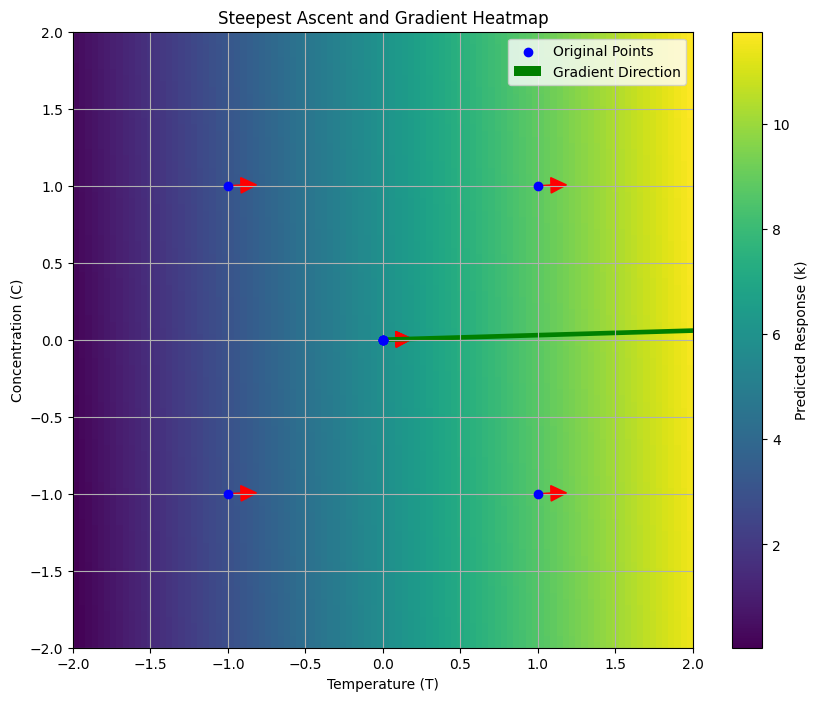

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Your data
data = {'T': [-1, 1, -1, 1, 0, 0, 0,0, 0],
        'c': [-1, -1, 1, 1, 0, 0, 0,0, 0],
        'A': [15,35,15,35,25,25,25,25,25],
        'B': [1.95,1.95,2.05,2.05,2.0,2.0,2.0,2.0,2.0],
        'k': [3.161645078398407, 8.818603462257467, 3.3010259130332984, 9.016058995325636, 5.68320685229769,5.789504000747021,5.863166591162294,5.647103571513824,5.747158560790277]}

df = pd.DataFrame(data)

# Define independent variables and response variable
X = df[['T', 'c']]  # Independent variables (coded)
y = df['k']  # Response variable

# Add an intercept to the model (constant term)
X = np.column_stack((np.ones(X.shape[0]), X))

# Compute the coefficients (gradient direction)
coeffs = np.linalg.lstsq(X, y, rcond=None)[0]

# Extract the gradient components
intercept, grad_T, grad_c = coeffs

# Step size for steepest ascent
step_size = grad_c/grad_T

# Calculate the step directions
step_T = step_size * grad_T
step_c = step_size * grad_c

# Create a grid of T and c values for the heatmap
T_values = np.linspace(-2, 2, 100)  # T values range
c_values = np.linspace(-2, 2, 100)  # c values range
T_grid, c_grid = np.meshgrid(T_values, c_values)

# Compute the predicted response over the grid
k_grid = intercept + grad_T * T_grid + grad_c * c_grid

# Visualize the gradient as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(k_grid, extent=[-2, 2, -2, 2], origin='lower', aspect='auto', cmap='viridis')

# Add colorbar to show the hue (response values) which is the results gathered from Erik
plt.colorbar(label='Predicted Response (k)')

# Plot the original points
plt.scatter(df['T'], df['c'], color='blue', label='Original Points', zorder=5)

# Plot arrows showing the direction of the steepest ascent from each point
for i in range(len(df)):
    plt.arrow(df['T'][i], df['c'][i], step_T, step_c,
              head_width=0.1, head_length=0.1, fc='red', ec='red')

# Plot the gradient vector at the origin, to easier understand the direction to find the maximum value
plt.quiver(0, 0, grad_T, grad_c, angles='xy', scale_units='xy', scale=1, color='green', label='Gradient Direction')

plt.xlabel('Temperature (T)')
plt.ylabel('Concentration (C)')
plt.title('Steepest Ascent and Gradient Heatmap')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
step = grad_c/grad_T
step

0.029619822412428998

Steepest ascent performed to find the new interval to preform the box plot.


In [14]:
Origin = [24,2-step]
delta= [1,step]
march=[]
for i in range(0,15):
    march.append((Origin[0]+(i+1)*delta[0],Origin[1]+(i+1)*delta[1]))

March=pd.DataFrame(march,columns=['T', 'c'])
March

,T,c
0,25,2.000000
1,26,2.029620
2,27,2.059240
3,28,2.088859
4,29,2.118479
5,30,2.148099
6,31,2.177719
7,32,2.207339
8,33,2.236959
9,34,2.266578


Generating data points around the maximum found in the first round

In [15]:

inputs_labels = {'A' : 'Temperature',
                 'B' : 'Concentration',
                 }

dat = [('A',32,38),
       ('B',2.207339, 2.385058),
     ]

inputs_df = pd.DataFrame(dat,columns=['index','low','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

inputs_df

,low,high,label
index,,,
A,32.000000,38.000000,Temperature
B,2.207339,2.385058,Concentration


In [16]:
import itertools
# we have four repetitions
encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded = pd.DataFrame(encoded_inputs, columns=['T', 'c'])
encoded

,T,c
0,-1,-1
1,-1,1
2,1,-1
3,1,1


In [17]:
def decode_input(encoded_input, inputs_df):
    decoded_values = []
    for idx, val in enumerate(encoded_input):
        if val == -1:
            decoded_values.append(inputs_df.iloc[idx]['low'])
        else:
            decoded_values.append(inputs_df.iloc[idx]['high'])
    return decoded_values

# Apply the decoding function to each encoded input
decoded_experiments = [decode_input(encoded_input, inputs_df) for encoded_input in encoded_inputs]

# Create a new DataFrame with the decoded values
decoded_df = pd.DataFrame(decoded_experiments, columns=inputs_labels)
decoded_df.head()

,A,B
0,32.0,2.207339
1,32.0,2.385058
2,38.0,2.207339
3,38.0,2.385058


In [18]:
new_results = [8.789826866562874, 9.173031362039227, 9.913108913074604, 10.516592175016205]
new_df = pd.DataFrame(new_results, columns=['a'])
results_again = pd.concat([decoded_df,new_df], axis=1)
results_again

,A,B,a
0,32.0,2.207339,8.789827
1,32.0,2.385058,9.173031
2,38.0,2.207339,9.913109
3,38.0,2.385058,10.516592


In [19]:
df = pd.concat([encoded,results_again], axis=1)
df

,T,c,A,B,a
0,-1,-1,32.0,2.207339,8.789827
1,-1,1,32.0,2.385058,9.173031
2,1,-1,38.0,2.207339,9.913109
3,1,1,38.0,2.385058,10.516592


In [20]:
y1 = df['a']
xlabs=['T','c']
x = df[xlabs]
x = sm.add_constant(x)

res1 = smf.ols(formula='y1 ~ T + c + T:c', data=df).fit()

res1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1527: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normal

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     y1   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 11 Oct 2024   Prob (F-statistic):                nan
Time:                        12:14:10   Log-Likelihood:                 131.57
No. Observations:                   4   AIC:                            -255.1
Df Residuals:                       0   BIC:                            -257.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5981        inf          0        nan         nan         nan
T              0.6167        inf          0        nan         nan         nan
c              0.2467        inf          0        nan         nan         nan
T:c            0.0551        inf          0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.500
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.167
Skew:                           0.000   Prob(JB):                        0.920
Kurtosis:                       2.000   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
labels = ['T','c']
ybar = df['a'].mean()
print(ybar)

main_effects = {}

print('main effects')
for key in labels:
        average_effects = df.groupby(key)['a'].mean()
        main_effects[key] = sum( [i*average_effects[i] for i in [-1,1]])
print(main_effects)

9.598139829173228
main effects
{'T': 1.2334214297443538, 'c': 0.493343878708977}


In [22]:
step_size = 0.493343878708977/1.2334214297443538

In [23]:
twoway_labels = list(itertools.combinations(labels, 2))


twoway_effects = {}
for key in twoway_labels:

    effects = df.groupby([key[0],key[1]])['a'].mean()

    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
twoway_effects

{('T', 'c'): 0.11013938323262451}

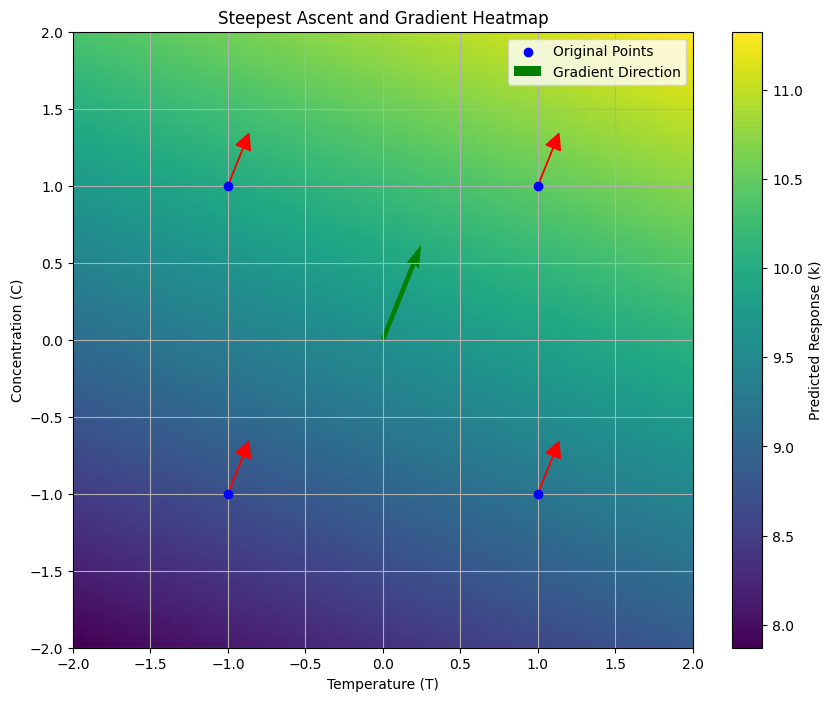

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Your data
data = {'T': [-1, 1, -1, 1],
        'c': [-1, -1, 1, 1],
        'A': [32,32, 38, 38],
        'B': [2.207339,2.385058,2.207339,2.385058],
        'k': [8.789826866562874, 9.173031362039227, 9.913108913074604, 10.516592175016205]}

df = pd.DataFrame(data)

# Define independent variables and response variable
X = df[['T', 'c']]  # Independent variables (coded)
y = df['k']  # Response variable

# Add an intercept to the model (constant term)
X = np.column_stack((np.ones(X.shape[0]), X))

# Compute the coefficients (gradient direction)
coeffs = np.linalg.lstsq(X, y, rcond=None)[0]

# Extract the gradient components
intercept, grad_T, grad_c = coeffs

# Step size for steepest ascent (adjustable)
step_size = grad_T/grad_c

# Calculate the step directions
step_T = step_size * grad_T
step_c = step_size * grad_c

# Create a grid of T and c values for the heatmap
T_values = np.linspace(-2, 2, 100)  # T values range
c_values = np.linspace(-2, 2, 100)  # c values range
T_grid, c_grid = np.meshgrid(T_values, c_values)

# Compute the predicted response over the grid
k_grid = intercept + grad_T * T_grid + grad_c * c_grid

# Visualize the gradient as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(k_grid, extent=[-2, 2, -2, 2], origin='lower', aspect='auto', cmap='viridis')

# Add colorbar to show the hue (response values)
plt.colorbar(label='Predicted Response (k)')

# Plot the original points
plt.scatter(df['T'], df['c'], color='blue', label='Original Points', zorder=5)

# Plot arrows showing the direction of the steepest ascent from each point
for i in range(len(df)):
    plt.arrow(df['T'][i], df['c'][i], step_T, step_c,
              head_width=0.1, head_length=0.1, fc='red', ec='red')

# Plot the gradient vector at the origin
plt.quiver(0, 0, grad_T, grad_c, angles='xy', scale_units='xy', scale=1, color='green', label='Gradient Direction')

# Labels and title
plt.xlabel('Temperature (T)')
plt.ylabel('Concentration (C)')
plt.title('Steepest Ascent and Gradient Heatmap')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [25]:
step_size

0.3999799799256203

In [26]:
Origin = [34,2.296198-step_size] #starting with the centerpoints
delta= [1,step_size]
march=[]
for i in range(0,15):
    march.append((Origin[0]+(i+1)*delta[0],Origin[1]+(i+1)*delta[1]))

March=pd.DataFrame(march,columns=['T', 'c'])
March

,T,c
0,35,2.296198
1,36,2.696178
2,37,3.096158
3,38,3.496138
4,39,3.896118
5,40,4.296098
6,41,4.696078
7,42,5.096058
8,43,5.496038
9,44,5.896018


In [27]:
inputs_labels = {'A' : 'Temperature',
                 'B' : 'Concentration',
                 }

dat = [('A',36,40),
       ('B',2.696178,4.296098),
     ]

inputs_df = pd.DataFrame(dat,columns=['index','low','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

inputs_df

,low,high,label
index,,,
A,36.000000,40.000000,Temperature
B,2.696178,4.296098,Concentration


In [28]:
import itertools
# we have four repetitions
encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded = pd.DataFrame(encoded_inputs, columns=['T', 'c'])


In [29]:
results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['T','c']
results

,T,c
0,-1,-1
1,1,-1
2,-1,1
3,1,1


In [30]:
def decode_input(encoded_input, inputs_df):
    decoded_values = []
    for idx, val in enumerate(encoded_input):
        if val == -1:
            decoded_values.append(inputs_df.iloc[idx]['low'])
        else:
            decoded_values.append(inputs_df.iloc[idx]['high'])
    return decoded_values

# Apply the decoding function to each encoded input
decoded_experiments = [decode_input(encoded_input, inputs_df) for encoded_input in encoded_inputs]

# Create a new DataFrame with the decoded values
decoded_df = pd.DataFrame(decoded_experiments, columns=inputs_labels)
decoded_df

,A,B
0,36.0,2.696178
1,36.0,4.296098
2,40.0,2.696178
3,40.0,4.296098


New results from Erik

In [31]:
results_new =  [11.29142988353728, 13.1136156068314, 12.054290377672046, 13.204506237468504]
res_df = pd.DataFrame(results_new, columns=['k'])
df = pd.concat([results,decoded_df,res_df ], axis=1)
df

,T,c,A,B,k
0,-1,-1,36.0,2.696178,11.291430
1,1,-1,36.0,4.296098,13.113616
2,-1,1,40.0,2.696178,12.054290
3,1,1,40.0,4.296098,13.204506


In [32]:
labels = ['T','c']
ybar = df['k'].mean()
print(ybar)

main_effects = {}

print('main effects')
for key in labels:
        average_effects = df.groupby(key)['k'].mean()
        main_effects[key] = sum([i*average_effects[i] for i in [-1,1]])
print(main_effects)

12.415960526377308
main effects
{'T': 1.4862007915452882, 'c': 0.42687556238593594}


In [33]:
b =0.42687556238593594/1.4862007915452882

In [34]:
twoway_labels = list(itertools.combinations(labels, 2))


twoway_effects = {}
for key in twoway_labels:

    effects = df.groupby([key[0],key[1]])['k'].mean()

    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
twoway_effects

{('T', 'c'): -0.3359849317488317}

In [35]:
Origin = [35,2.696178-0.28722603622225834] #starting with the centerpoints
delta= [1,0.28722603622225834]
march=[]
for i in range(0,15):
    march.append((Origin[0]+(i+1)*delta[0],Origin[1]+(i+1)*delta[1]))

March=pd.DataFrame(march,columns=['T', 'c'])
March

,T,c
0,36,2.696178
1,37,2.983404
2,38,3.270630
3,39,3.557856
4,40,3.845082
5,41,4.132308
6,42,4.419534
7,43,4.706760
8,44,4.993986
9,45,5.281212


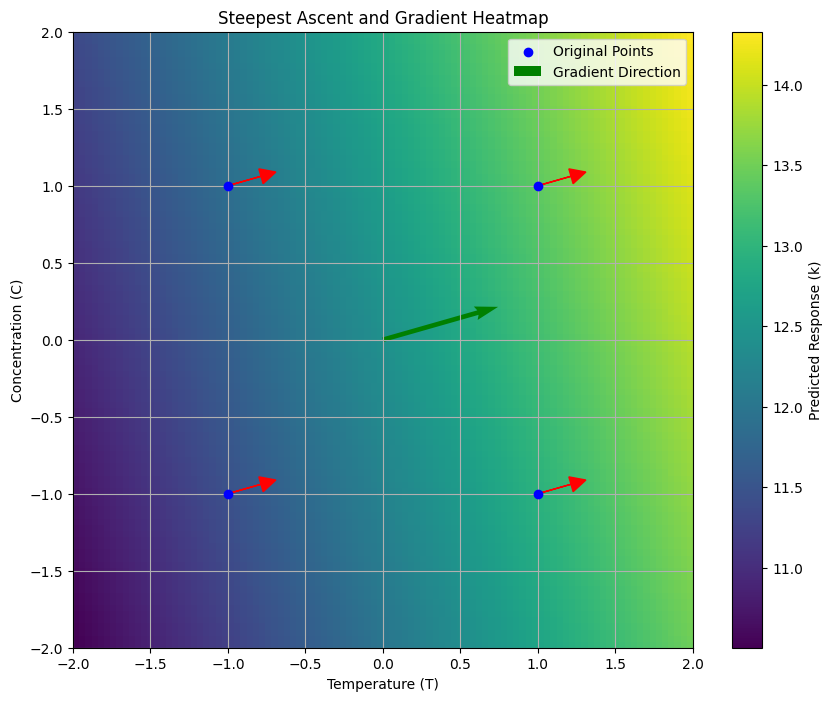

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Your data
data = {'T': [-1, 1, -1, 1],
        'c': [-1, -1, 1, 1],
        'A': [36,36, 40, 40],
        'B': [2.696178,4.296098,2.696178,4.296098],
        'k': [11.29142988353728, 13.1136156068314, 12.054290377672046, 13.204506237468504]}

df = pd.DataFrame(data)

# Define independent variables and response variable
X = df[['T', 'c']]  # Independent variables (coded)
y = df['k']  # Response variable

# Add an intercept to the model (constant term)
X = np.column_stack((np.ones(X.shape[0]), X))

# Compute the coefficients (gradient direction)
coeffs = np.linalg.lstsq(X, y, rcond=None)[0]

# Extract the gradient components
intercept, grad_T, grad_c = coeffs

# Step size for steepest ascent (adjustable)
step_size = grad_c/grad_T

# Calculate the step directions
step_T = step_size * grad_T
step_c = step_size * grad_c

# Create a grid of T and c values for the heatmap
T_values = np.linspace(-2, 2, 100)  # T values range
c_values = np.linspace(-2, 2, 100)  # c values range
T_grid, c_grid = np.meshgrid(T_values, c_values)

# Compute the predicted response over the grid
k_grid = intercept + grad_T * T_grid + grad_c * c_grid

# Visualize the gradient as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(k_grid, extent=[-2, 2, -2, 2], origin='lower', aspect='auto', cmap='viridis')

# Add colorbar to show the hue (response values)
plt.colorbar(label='Predicted Response (k)')

# Plot the original points
plt.scatter(df['T'], df['c'], color='blue', label='Original Points', zorder=5)

# Plot arrows showing the direction of the steepest ascent from each point
for i in range(len(df)):
    plt.arrow(df['T'][i], df['c'][i], step_T, step_c,
              head_width=0.1, head_length=0.1, fc='red', ec='red')

# Plot the gradient vector at the origin
plt.quiver(0, 0, grad_T, grad_c, angles='xy', scale_units='xy', scale=1, color='green', label='Gradient Direction')

# Labels and title
plt.xlabel('Temperature (T)')
plt.ylabel('Concentration (C)')
plt.title('Steepest Ascent and Gradient Heatmap')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [37]:
step = step_c/step_T
step

0.2872260362222587

In [38]:
Origin = [35,2.696178-step] #starting with the centerpoints
delta= [1,step]
march=[]
for i in range(0,10):
    march.append((Origin[0]+(i+1)*delta[0],Origin[1]+(i+1)*delta[1]))

March=pd.DataFrame(march,columns=['T', 'c'])
March

,T,c
0,36,2.696178
1,37,2.983404
2,38,3.270630
3,39,3.557856
4,40,3.845082
5,41,4.132308
6,42,4.419534
7,43,4.706760
8,44,4.993986
9,45,5.281212


My new guess, this time a bit more bold move according to the stepsize from the steepest ascent.

In [39]:
inputs_labels = {'A' : 'Temperature',
                 'B' : 'Concentration',
                 }

dat = [('A',38,40),
       ('B',3.270630,3.845082),
     ]

inputs_df = pd.DataFrame(dat,columns=['index','low','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

inputs_df

,low,high,label
index,,,
A,38.00000,40.000000,Temperature
B,3.27063,3.845082,Concentration


In [40]:
def decode_input(encoded_input, inputs_df):
    decoded_values = []
    for idx, val in enumerate(encoded_input):
        if val == -1:
            decoded_values.append(inputs_df.iloc[idx]['low'])
        else:
            decoded_values.append(inputs_df.iloc[idx]['high'])
    return decoded_values

# Apply the decoding function to each encoded input
decoded_experiments = [decode_input(encoded_input, inputs_df) for encoded_input in encoded_inputs]

# Create a new DataFrame with the decoded values
decoded_df = pd.DataFrame(decoded_experiments, columns=inputs_labels)
decoded_df

,A,B
0,38.0,3.270630
1,38.0,3.845082
2,40.0,3.270630
3,40.0,3.845082


In [41]:
results_new =  [12.88124365039067, 13.72165240967948, 13.2969242613669, 14.246667393178383]
res_df = pd.DataFrame(results_new, columns=['k'])
df = pd.concat([results,decoded_df,res_df ], axis=1)
df

,T,c,A,B,k
0,-1,-1,38.0,3.270630,12.881244
1,1,-1,38.0,3.845082,13.721652
2,-1,1,40.0,3.270630,13.296924
3,1,1,40.0,3.845082,14.246667


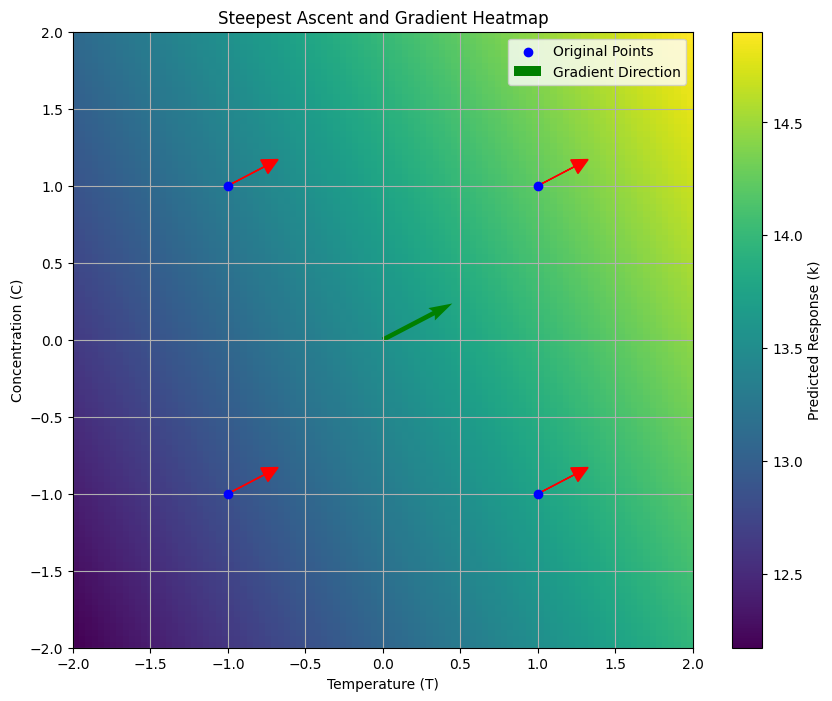

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Your data
data = {'T': [-1, 1, -1, 1],
        'c': [-1, -1, 1, 1],
        'A': [38,38, 40, 40],
        'B': [3.270630, 3.845082,3.270630, 3.845082],
        'k': [12.88124365039067, 13.72165240967948, 13.2969242613669, 14.246667393178383]}

df = pd.DataFrame(data)

# Define independent variables and response variable
X = df[['T', 'c']]  # Independent variables (coded)
y = df['k']  # Response variable

# Add an intercept to the model (constant term)
X = np.column_stack((np.ones(X.shape[0]), X))

# Compute the coefficients (gradient direction)
coeffs = np.linalg.lstsq(X, y, rcond=None)[0]

# Extract the gradient components
intercept, grad_T, grad_c = coeffs

# Step size for steepest ascent (adjustable)
step_size = grad_c/grad_T

# Calculate the step directions
step_T = step_size * grad_T
step_c = step_size * grad_c

# Create a grid of T and c values for the heatmap
T_values = np.linspace(-2, 2, 100)  # T values range
c_values = np.linspace(-2, 2, 100)  # c values range
T_grid, c_grid = np.meshgrid(T_values, c_values)

# Compute the predicted response over the grid
k_grid = intercept + grad_T * T_grid + grad_c * c_grid

# Visualize the gradient as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(k_grid, extent=[-2, 2, -2, 2], origin='lower', aspect='auto', cmap='viridis')

# Add colorbar to show the hue (response values)
plt.colorbar(label='Predicted Response (k)')

# Plot the original points
plt.scatter(df['T'], df['c'], color='blue', label='Original Points', zorder=5)

# Plot arrows showing the direction of the steepest ascent from each point
for i in range(len(df)):
    plt.arrow(df['T'][i], df['c'][i], step_T, step_c,
              head_width=0.1, head_length=0.1, fc='red', ec='red')

# Plot the gradient vector at the origin
plt.quiver(0, 0, grad_T, grad_c, angles='xy', scale_units='xy', scale=1, color='green', label='Gradient Direction')

# Labels and title
plt.xlabel('Temperature (T)')
plt.ylabel('Concentration (C)')
plt.title('Steepest Ascent and Gradient Heatmap')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [44]:
labels = ['T','c']
ybar = df['k'].mean()
print(ybar)

main_effects = {}

print('main effects')
for key in labels:
        average_effects = df.groupby(key)['k'].mean()
        main_effects[key] = sum([i*average_effects[i] for i in [-1,1]])
print(main_effects)

13.536621928653858
main effects
{'T': 0.8950759455501469, 'c': 0.47034779723756515}


In [45]:
c = main_effects['c']/main_effects['T']
c

0.525483674961762

In [46]:
twoway_labels = list(itertools.combinations(labels, 2))


twoway_effects = {}
for key in twoway_labels:

    effects = df.groupby([key[0],key[1]])['k'].mean()

    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
twoway_effects

{('T', 'c'): 0.054667186261336376}

In [47]:
Origin = [39,3.845082-c] #starting with the centerpoints
delta= [1,c]
march=[]
for i in range(0,15):
    march.append((Origin[0]+(i+1)*delta[0],Origin[1]+(i+1)*delta[1]))

March=pd.DataFrame(march,columns=['T', 'c'])
March

,T,c
0,40,3.845082
1,41,4.370566
2,42,4.896049
3,43,5.421533
4,44,5.947017
5,45,6.472500
6,46,6.997984
7,47,7.523468
8,48,8.048951
9,49,8.574435


In [48]:
inputs_labels = {'A' : 'Temperature',
                 'B' : 'Concentration',
                 }

dat = [('A',40,42),
       ('B',3.845082, 4.896049) ]

inputs_df = pd.DataFrame(dat,columns=['index','low','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

inputs_df

,low,high,label
index,,,
A,40.000000,42.000000,Temperature
B,3.845082,4.896049,Concentration


In [49]:
def decode_input(encoded_input, inputs_df):
    decoded_values = []
    for idx, val in enumerate(encoded_input):
        if val == -1:
            decoded_values.append(inputs_df.iloc[idx]['low'])
        else:
            decoded_values.append(inputs_df.iloc[idx]['high'])
    return decoded_values

# Apply the decoding function to each encoded input
decoded_experiments = [decode_input(encoded_input, inputs_df) for encoded_input in encoded_inputs]

# Create a new DataFrame with the decoded values
decoded_df = pd.DataFrame(decoded_experiments, columns=inputs_labels)
decoded_df

,A,B
0,40.0,3.845082
1,40.0,4.896049
2,42.0,3.845082
3,42.0,4.896049


Results from Erik

In [50]:
results_new =  [14.247795674428074,
 11.216353445970551,
 13.602650822947409,
 10.850462671572402]
res_df = pd.DataFrame(results_new, columns=['k'])
df = pd.concat([results,decoded_df,res_df ], axis=1)
df

,T,c,A,B,k
0,-1,-1,40.0,3.845082,14.247796
1,1,-1,40.0,4.896049,11.216353
2,-1,1,42.0,3.845082,13.602651
3,1,1,42.0,4.896049,10.850463


In [51]:
labels = ['T','c']
ybar = df['k'].mean()
print(ybar)

main_effects = {}

print('main effects')
for key in labels:
        average_effects = df.groupby(key)['k'].mean()
        main_effects[key] = sum([i*average_effects[i] for i in [-1,1]])
print(main_effects)

12.479315653729609
main effects
{'T': -2.891815189916265, 'c': -0.5055178129394058}


In [52]:
c = main_effects['c']/main_effects['T']
c

0.1748098615368444

In [53]:
twoway_labels = list(itertools.combinations(labels, 2))


twoway_effects = {}
for key in twoway_labels:

    effects = df.groupby([key[0],key[1]])['k'].mean()

    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
twoway_effects

{('T', 'c'): 0.13962703854125813}

Now one can see that the maximum point has been reached and the values are starting to go down again. This means that the maximum point will be around 14.2, hence one can continue with latinhypercube design.

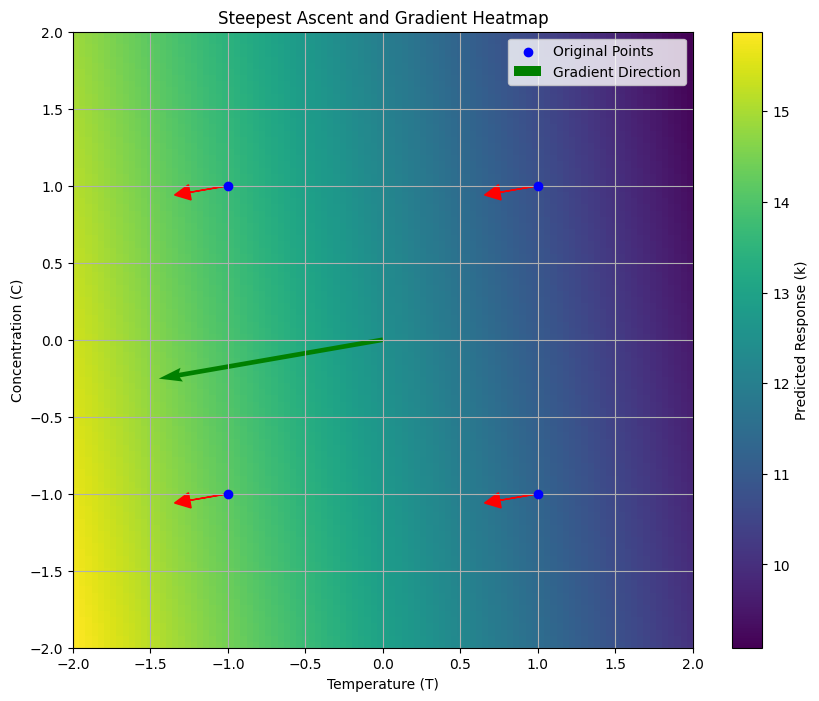

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Your data
data = {'T': [-1, 1, -1, 1],
        'c': [-1, -1, 1, 1],
        'A': [40, 40, 42, 42],
        'B': [3.845082, 4.896049, 3.845082, 4.896049],
        'k': [14.247796, 11.216353, 13.602651, 10.850463]}

df = pd.DataFrame(data)

# Define independent variables and response variable
X = df[['T', 'c']]  # Independent variables (coded)
y = df['k']  # Response variable

# Add an intercept to the model (constant term)
X = np.column_stack((np.ones(X.shape[0]), X))

# Compute the coefficients (gradient direction)
coeffs = np.linalg.lstsq(X, y, rcond=None)[0]

# Extract the gradient components
intercept, grad_T, grad_c = coeffs

# Step size for steepest ascent (adjustable)
step_size = 0.17

# Calculate the step directions
step_T = step_size * grad_T
step_c = step_size * grad_c

# Create a grid of T and c values for the heatmap
T_values = np.linspace(-2, 2, 100)  # T values range
c_values = np.linspace(-2, 2, 100)  # c values range
T_grid, c_grid = np.meshgrid(T_values, c_values)

# Compute the predicted response over the grid
k_grid = intercept + grad_T * T_grid + grad_c * c_grid

# Visualize the gradient as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(k_grid, extent=[-2, 2, -2, 2], origin='lower', aspect='auto', cmap='viridis')

# Add colorbar to show the hue (response values)
plt.colorbar(label='Predicted Response (k)')

# Plot the original points
plt.scatter(df['T'], df['c'], color='blue', label='Original Points', zorder=5)

# Plot arrows showing the direction of the steepest ascent from each point
for i in range(len(df)):
    plt.arrow(df['T'][i], df['c'][i], step_T, step_c,
              head_width=0.1, head_length=0.1, fc='red', ec='red')

# Plot the gradient vector at the origin
plt.quiver(0, 0, grad_T, grad_c, angles='xy', scale_units='xy', scale=1, color='green', label='Gradient Direction')

# Labels and title
plt.xlabel('Temperature (T)')
plt.ylabel('Concentration (C)')
plt.title('Steepest Ascent and Gradient Heatmap')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


Doing latin hypercube design

In [56]:
pip install pyDOE

This is the latin hypercube design method to find the maximum point by looking at a specific centerpoint.

   Temperature  Concentration
0    38.858480       3.721187
1    39.592318       3.763914
2    39.063230       3.825651
3    39.428756       3.814704
4    40.281952       3.741121
5    39.236021       3.772708
6    39.740946       3.678668
7    40.191881       3.845197
8    39.981393       3.702801
9    40.545701       3.794035


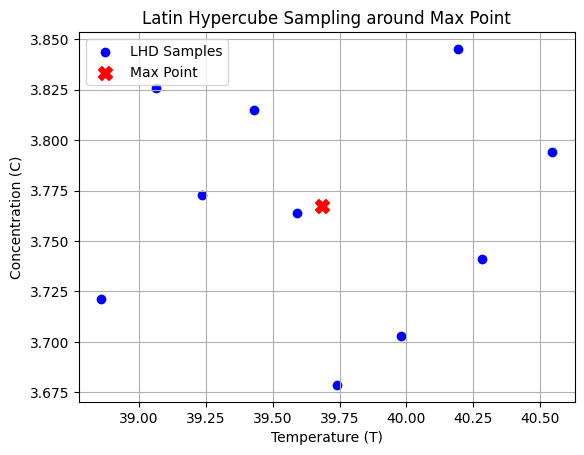

In [57]:
import numpy as np
import pandas as pd
from pyDOE import lhs

#Identify the maximum point
T_max = 39.683139  # maximum temperature
C_max =  3.767561  # maximum concentration

#Define the range around the maximum point
range_factor= 0.025 # 10% range around the max

T_range = (T_max * (1 - range_factor), T_max * (1 + range_factor))
C_range = (C_max * (1 - range_factor), C_max * (1 + range_factor))

#Generating Latin Hypercube Sample
n_samples = 10  # Number of samples to generate
lhs_samples = lhs(2, samples=n_samples)  # 2 dimensions: T and C

# Scale the samples to the defined ranges
T_samples = T_range[0] + lhs_samples[:, 0] * (T_range[1] - T_range[0])
C_samples = C_range[0] + lhs_samples[:, 1] * (C_range[1] - C_range[0])

# Create a DataFrame to hold the samples
samples_df = pd.DataFrame({
    'Temperature': T_samples,
    'Concentration': C_samples
})

print(samples_df)

plt.scatter(samples_df['Temperature'], samples_df['Concentration'], color='blue', label='LHD Samples')
plt.scatter(T_max, C_max, color='red', label='Max Point', marker='X', s=100)  # Mark the max point
plt.xlabel('Temperature (T)')
plt.ylabel('Concentration (C)')
plt.title('Latin Hypercube Sampling around Max Point')
plt.legend()
plt.grid(True)
plt.show()


In [58]:
results1 = [14.115439573640463,14.141849859864768,13.527101485833548,14.02617932344199,13.725438615991477,14.28975067289101,14.234519962853042,13.960851842801786,13.724277431898084,13.99722591523255]
T = [39.098076,38.871342,39.484456,40.755152,39.336821,39.683139,40.48362,40.281918,40.149173,39.797023 ]
c =[  3.844938, 3.829346, 3.812276,  3.794479 , 3.756034 ,3.767561,3.871259 ,  3.733821,  3.878709 ,3.901876]
final1 = pd.DataFrame(list(zip(T, c, results1)), columns=['Temperature', 'Concentration', 'Response'])
final1

,Temperature,Concentration,Response
0,39.098076,3.844938,14.115440
1,38.871342,3.829346,14.141850
2,39.484456,3.812276,13.527101
3,40.755152,3.794479,14.026179
4,39.336821,3.756034,13.725439
5,39.683139,3.767561,14.289751
6,40.483620,3.871259,14.234520
7,40.281918,3.733821,13.960852
8,40.149173,3.878709,13.724277
9,39.797023,3.901876,13.997226


In [59]:
results_new =  [14.247795674428074,
 11.216353445970551,
 13.602650822947409,
 10.850462671572402]
res_df = pd.DataFrame(results_new, columns=['k'])
df = pd.concat([results,decoded_df,res_df ], axis=1)
df

,T,c,A,B,k
0,-1,-1,40.0,3.845082,14.247796
1,1,-1,40.0,4.896049,11.216353
2,-1,1,42.0,3.845082,13.602651
3,1,1,42.0,4.896049,10.850463


The input values T and c was gathered from the LCH method which randomize 10 values around the highest center point. Used T= 39.683139	and c= 3.767561 since they had the maximum response and then generated ten new values from LCH.

In [60]:
final_results = [13.89586928595527,13.826316547204614,14.410021736979829,14.102844742315947,13.876966735543263,13.968922384600504,13.814167533865128,13.620097781597847,14.113054643805484,13.972436045450864]
T = [40.477546, 38.752121, 39.665423 , 40.096731,39.023524,39.934096,39.441850 , 39.809998  ,40.291793 ,39.096252]
c = [3.850130,   3.794784,  3.768585, 3.753789,  3.726664, 3.813758, 3.689155, 3.841206, 3.693571, 3.730200]
final = pd.DataFrame(list(zip(T, c, final_results)), columns=['Temperature', 'Concentration', 'Response'])
final


,Temperature,Concentration,Response
0,40.477546,3.850130,13.895869
1,38.752121,3.794784,13.826317
2,39.665423,3.768585,14.410022
3,40.096731,3.753789,14.102845
4,39.023524,3.726664,13.876967
5,39.934096,3.813758,13.968922
6,39.441850,3.689155,13.814168
7,39.809998,3.841206,13.620098
8,40.291793,3.693571,14.113055
9,39.096252,3.730200,13.972436


The final results could be estimated to T = 39.665423	c = 3.768585	response = 14.410022